<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch_%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92ghostnet_StawberryApple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch : RESNET18を用いたdeep learning（転移学習も）

http://torch.classcat.com/2018/04/29/pytorch-tutorial-transfer-learning/


#自作データ、Early stopping

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline


plt.ion()   # interactive mode

#Google driveのデータをマウント
データの位置
/content/drive/My drive/AI_laboratory_course

In [2]:
'''
フォルダ構成(※class名は4文字にすること)
---dataset.zip-----train-----appl
               |          |--stra
               |
               |---val-------appl
                          |--stra
'''


from google.colab import drive
drive.mount('/content/drive')

#dataset.zipを解凍

!date -R
!unzip -qq drive/My\ Drive/AI_laboratory_course/dataset.zip
!date -R
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Sat, 21 Mar 2020 14:39:59 +0000
Sat, 21 Mar 2020 14:40:14 +0000
drive  sample_data  train  val


#データをロードする
データをロードするために torchvision と torch.utils.data パッケージを使用します。Trainとvalに分けて読み込みます。

In [3]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path= data_dir + '/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path= data_dir + '/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))

['appl', 'stra']
appl_train:252
stra_train:252
appl_val:67
stra_val:60
training data set_total：504
validating data set_total：127


#少数の画像を可視化する

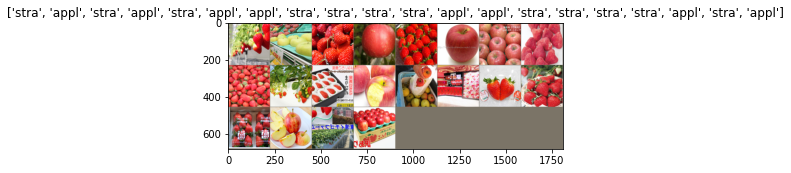

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#Define the Early Stopping Class

In [0]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

#モデルを訓練する
さて、モデルを訓練するための一般的な関数を書きましょう。ここで、次を示します :

学習率をスケジューリングする
ベスト・モデルをセーブする
以下で、パラメータ scheduler は torch.optim.lr_scheduler からの LR scheduler オブジェクトです。

In [0]:
def train_model(model, criterion, optimizer, scheduler, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            
            # record train_loss and valid_loss
            if phase == 'train':
                train_loss.append(epoch_loss)
            if phase == 'val':
                valid_loss.append(epoch_loss)
            #print(train_loss)
            #print(valid_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
      
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
        if phase == 'val':    
            early_stopping(epoch_loss, model)
                
            if early_stopping.early_stop:
                print("Early stopping")
                break
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss

#モデル予測を可視化する
少数の画像のための予測を表示するための一般的な関数。

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#convnet を再調整する
モデルをロードして最後の完全結合層をリセットします。<br>
※pretrained = False　→事前訓練していない状態になります<br>
※pretrained = True　→事前訓練された状態（強化学習）

In [0]:
"""
Creates a GhostNet Model as defined in:
GhostNet: More Features from Cheap Operations By Kai Han, Yunhe Wang, Qi Tian, Jianyuan Guo, Chunjing Xu, Chang Xu.
https://arxiv.org/abs/1911.11907
Modified from https://github.com/d-li14/mobilenetv3.pytorch
"""
import torch
import torch.nn as nn
import math


__all__ = ['ghostnet']


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, channel // reduction),
                nn.ReLU(inplace=True),
                nn.Linear(channel // reduction, channel),        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        y = torch.clamp(y, 0, 1)
        return x * y


def depthwise_conv(inp, oup, kernel_size=3, stride=1, relu=False):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size, stride, kernel_size//2, groups=inp, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True) if relu else nn.Sequential(),
    )

class GhostModule(nn.Module):
    def __init__(self, inp, oup, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        self.oup = oup
        init_channels = math.ceil(oup / ratio)
        new_channels = init_channels*(ratio-1)

        self.primary_conv = nn.Sequential(
            nn.Conv2d(inp, init_channels, kernel_size, stride, kernel_size//2, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential(),
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv2d(init_channels, new_channels, dw_size, 1, dw_size//2, groups=init_channels, bias=False),
            nn.BatchNorm2d(new_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential(),
        )

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = torch.cat([x1,x2], dim=1)
        return out[:,:self.oup,:,:]


class GhostBottleneck(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se):
        super(GhostBottleneck, self).__init__()
        assert stride in [1, 2]

        self.conv = nn.Sequential(
            # pw
            GhostModule(inp, hidden_dim, kernel_size=1, relu=True),
            # dw
            depthwise_conv(hidden_dim, hidden_dim, kernel_size, stride, relu=False) if stride==2 else nn.Sequential(),
            # Squeeze-and-Excite
            SELayer(hidden_dim) if use_se else nn.Sequential(),
            # pw-linear
            GhostModule(hidden_dim, oup, kernel_size=1, relu=False),
        )

        if stride == 1 and inp == oup:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                depthwise_conv(inp, inp, 3, stride, relu=True),
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        return self.conv(x) + self.shortcut(x)


class GhostNet(nn.Module):
    def __init__(self, cfgs, num_classes=1000, width_mult=1.):
        super(GhostNet, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = cfgs

        # building first layer
        output_channel = _make_divisible(16 * width_mult, 4)
        layers = [nn.Sequential(
            nn.Conv2d(3, output_channel, 3, 2, 1, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)
        )]
        input_channel = output_channel

        # building inverted residual blocks
        block = GhostBottleneck
        for k, exp_size, c, use_se, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 4)
            hidden_channel = _make_divisible(exp_size * width_mult, 4)
            layers.append(block(input_channel, hidden_channel, output_channel, k, s, use_se))
            input_channel = output_channel
        self.features = nn.Sequential(*layers)

        # building last several layers
        output_channel = _make_divisible(exp_size * width_mult, 4)
        self.squeeze = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, 1, 1, 0, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        input_channel = output_channel

        output_channel = 1280
        self.classifier = nn.Sequential(
            nn.Linear(input_channel, output_channel, bias=False),
            nn.BatchNorm1d(output_channel),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(output_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


def ghostnet(**kwargs):
    """
    Constructs a GhostNet model
    """
    cfgs = [
        # k, t, c, SE, s 
        [3,  16,  16, 0, 1],
        [3,  48,  24, 0, 2],
        [3,  72,  24, 0, 1],
        [5,  72,  40, 1, 2],
        [5, 120,  40, 1, 1],
        [3, 240,  80, 0, 2],
        [3, 200,  80, 0, 1],
        [3, 184,  80, 0, 1],
        [3, 184,  80, 0, 1],
        [3, 480, 112, 1, 1],
        [3, 672, 112, 1, 1],
        [5, 672, 160, 1, 2],
        [5, 960, 160, 0, 1],
        [5, 960, 160, 1, 1],
        [5, 960, 160, 0, 1],
        [5, 960, 160, 1, 1]
    ]
    return GhostNet(cfgs, **kwargs)


class Flatten(nn.Module): 
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

In [66]:
model_ft = ghostnet().to(device)
model_ft.load_state_dict(torch.load('https://github.com/d-li14/ghostnet.pytorch/blob/master/pretrained/ghostnet_1x-9c40f966.pth'))

#print(model_ft)

#from torchsummary import summary
#summary(model_ft, (3,224,224))


FileNotFoundError: ignored

In [0]:
model_ft = nn.Sequential(*list(model_ft.children())[:-1], 
                         nn.Flatten(),
                         nn.Linear(960,1280,bias=False), 
                         nn.BatchNorm1d(1280), 
                         nn.ReLU(inplace=True), 
                         nn.Dropout(p=0.2,inplace=False),
                         nn.Linear(1280,2))
#print(model_ft)


In [0]:
#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#訓練と評価
CPU 上でおよそ 15-25 分かかるはずです。けれども GPU 上なら、1 分もかかりません。

In [62]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, patience=5, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6662 Acc: 0.6111
val Loss: 0.7451 Acc: 0.5276
Validation loss decreased (inf --> 0.745137).  Saving model ...

Epoch 1/24
----------
train Loss: 0.5841 Acc: 0.7024
val Loss: 0.7899 Acc: 0.5591
EarlyStopping counter: 1 out of 5

Epoch 2/24
----------
train Loss: 0.5506 Acc: 0.7222
val Loss: 1.2651 Acc: 0.7795
EarlyStopping counter: 2 out of 5

Epoch 3/24
----------
train Loss: 0.4985 Acc: 0.7599
val Loss: 0.7330 Acc: 0.7874
Validation loss decreased (0.745137 --> 0.733048).  Saving model ...

Epoch 4/24
----------
train Loss: 0.4863 Acc: 0.7679
val Loss: 0.3377 Acc: 0.8425
Validation loss decreased (0.733048 --> 0.337695).  Saving model ...

Epoch 5/24
----------
train Loss: 0.4429 Acc: 0.7857
val Loss: 0.5157 Acc: 0.8898
EarlyStopping counter: 1 out of 5

Epoch 6/24
----------
train Loss: 0.3773 Acc: 0.8194
val Loss: 0.3559 Acc: 0.8189
EarlyStopping counter: 2 out of 5

Epoch 7/24
----------
train Loss: 0.4079 Acc: 0.8274
val Loss: 0.3192 Acc: 0.8504
Validation loss decre

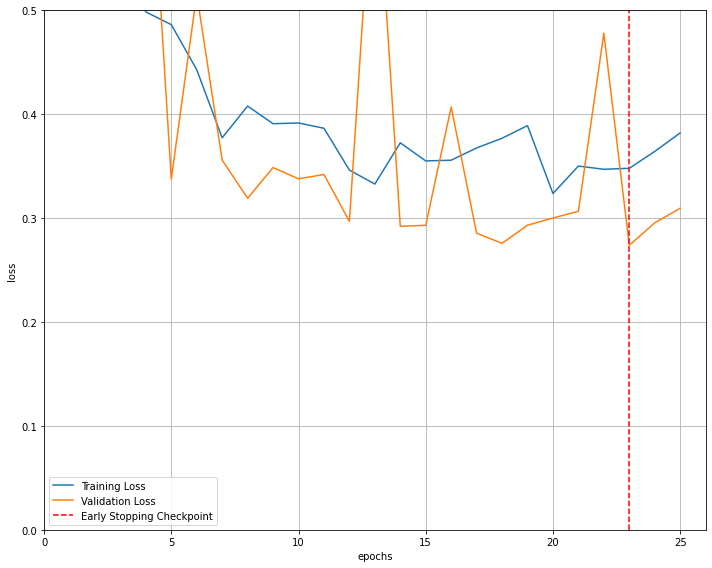

In [63]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

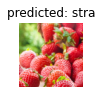

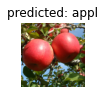

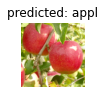

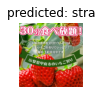

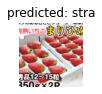

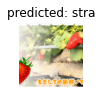

In [64]:
visualize_model(model_ft)

#Test datasetにおける正解率を（改めて）計算

In [65]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['val']:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the test images: 88 %


#ネットワークの保存

In [0]:
PATH = '/content/drive/My Drive/Deep_learning/applstra/applstra.pth'
torch.save(model_ft.state_dict(), PATH)